# 3. Simulating CRN
This tutorial has been adapted from the Catalyst.jl [docs](https://docs.sciml.ai/Catalyst/stable/introduction_to_catalyst/catalyst_for_new_julia_users/).

In [23]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/repos/JuliaTutorials`


In [24]:
using Catalyst
using OrdinaryDiffEq
using Plots
using Latexify

## Example 1: Birth-death process

In [25]:
rn = @reaction_network begin
    b, 0 --> X
    d, X --> 0
end

Model ##ReactionSystem#301:
Unknowns (1): see unknowns(##ReactionSystem#301)
  X(t)
Parameters (2): see parameters(##ReactionSystem#301)
  b
  d

In [26]:
# Alternative construction
rxns = [
    @reaction b, 0 --> X
    @reaction d, X --> 0
]
rn2 = ReactionSystem(rxns, name=:rn2)

Model rn2:
Unknowns (1): see unknowns(rn2)
  X(t)
Parameters (2): see parameters(rn2)
  b
  d

In [ ]:
latexify(rn, form=:ode)

In [ ]:
# Initial conditions
u0 = [:X => 1.0]
# parameter values
params = [:b => 1.0, :d => 0.2]
# Simulation timespan
tspan = (0.0, 10.0)

Note the `:` in front of `:X` indicates this is a Julia *Symbol*.

In [ ]:
oprob = ODEProblem(rn, u0, tspan, params)

In [ ]:
sol = solve(oprob)
sol[:X]

In [ ]:
plot(sol)

## Example 2: SIR model

In [ ]:
sir_model = @reaction_network SIR begin
    b, S + I --> 2I
    k, I --> R
end

In [ ]:
u0 = [:S => 50, :I => 1, :R => 0]
tspan = (0.0, 10.0)
params = [:b => 0.2, :k => 1.0]

In [ ]:
jinput = JumpInputs(sir_model, u0, tspan, params)
jprob = JumpProblem(jinput)

sol = solve(jprob)
plot(sol)

## Example 3: Repressilator

In [27]:
rn = @reaction_network Repressilator begin
    hillr(P₃,α,K,n), ∅ --> m₁
    hillr(P₁,α,K,n), ∅ --> m₂
    hillr(P₂,α,K,n), ∅ --> m₃
    (δ,γ), m₁ <--> ∅
    (δ,γ), m₂ <--> ∅
    (δ,γ), m₃ <--> ∅
    β, m₁ --> m₁ + P₁
    β, m₂ --> m₂ + P₂
    β, m₃ --> m₃ + P₃
    μ, P₁ --> ∅
    μ, P₂ --> ∅
    μ, P₃ --> ∅
end

Model Repressilator:
Unknowns (6): see unknowns(Repressilator)
  m₁(t)
  m₂(t)
  m₃(t)
  P₁(t)
  ⋮
Parameters (7): see parameters(Repressilator)
  α
  K
  n
  δ
  ⋮

In [28]:
@show species(rn)
@show parameters(rn)

species(rn) = SymbolicUtils.BasicSymbolic{Real}[m₁(t), m₂(t), m₃(t), P₁(t), P₂(t), P₃(t)]
parameters(rn) = Any[α, K, n, δ, γ, β, μ]


7-element Vector{Any}:
 α
 K
 n
 δ
 γ
 β
 μ

┌ Warning: Module SciMLBase with build ID fafbfcfd-1846-3315-6989-54dbd91c8e0f is missing from the cache.
│ This may mean SciMLBase [0bca4576-84f4-4d90-8ffe-ffa030f20462] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module Catalyst with build ID fafbfcfd-f77c-cdc5-ba6f-a5c1b5a9ee8b is missing from the cache.
│ This may mean Catalyst [479239e8-5488-4da2-87a7-35f2df7eef83] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module Catalyst with build ID fafbfcfd-f77c-cdc5-ba6f-a5c1b5a9ee8b is missing from the cache.
│ This may mean Catalyst [479239e8-5488-4da2-87a7-35f2df7eef83] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541


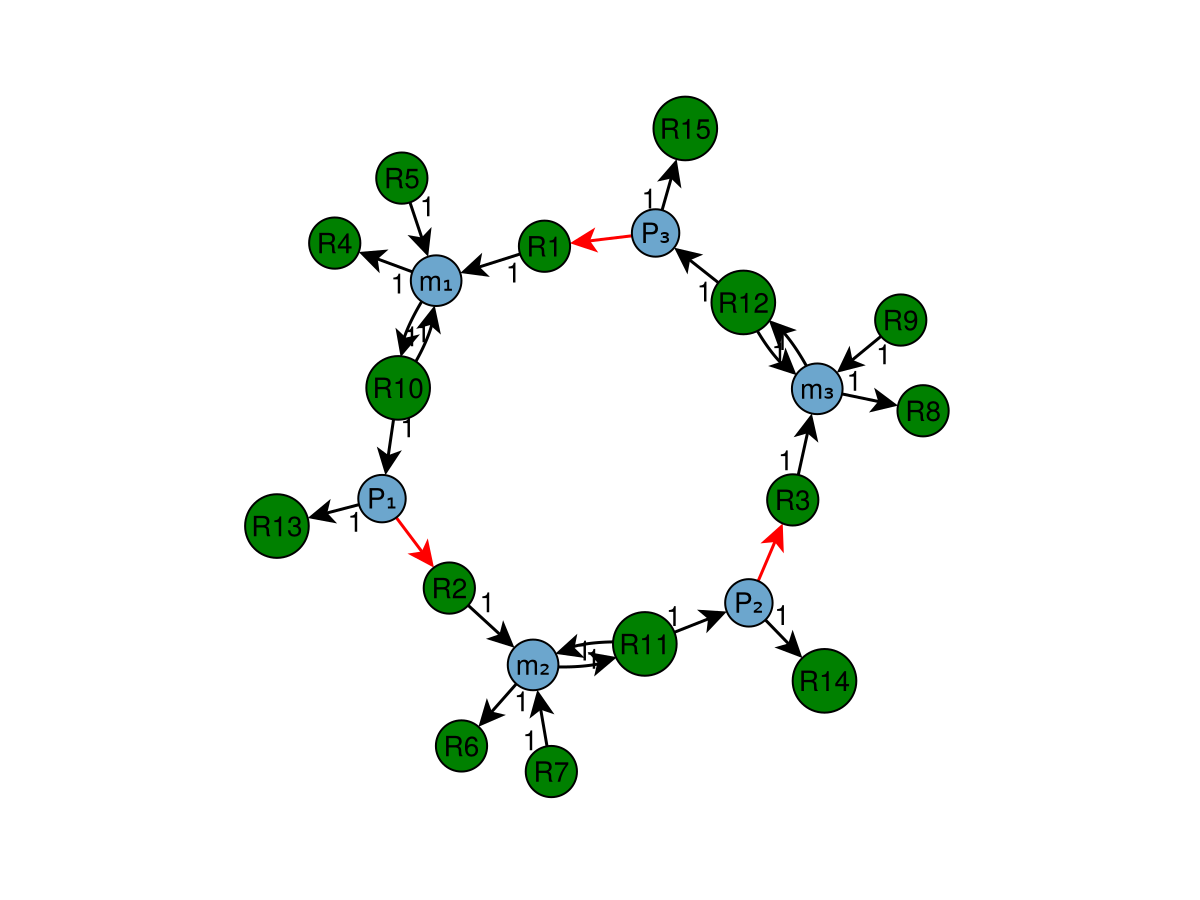

In [29]:
import CairoMakie, GraphMakie, NetworkLayout
g = plot_network(rn)

In [ ]:
# Optional
# save("repressilator_graph.png", g)

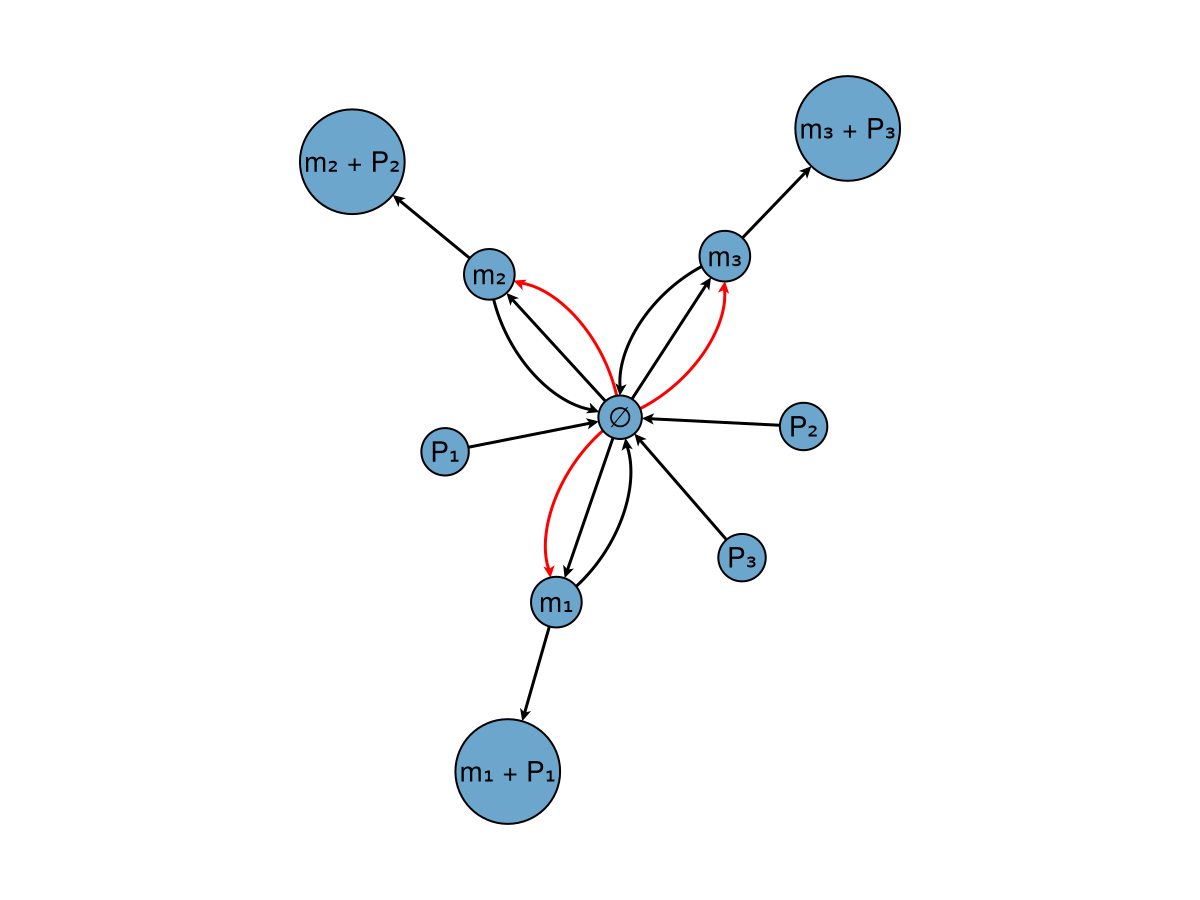

In [30]:
plot_complexes(rn)

In [31]:
odesys = convert(ODESystem, rn)

Model Repressilator:
Equations (6):
  6 standard: see equations(Repressilator)
Unknowns (6): see unknowns(Repressilator)
  m₁(t)
  m₂(t)
  m₃(t)
  P₁(t)
  ⋮
Parameters (7): see parameters(Repressilator)
  α
  K
  n
  δ
  ⋮

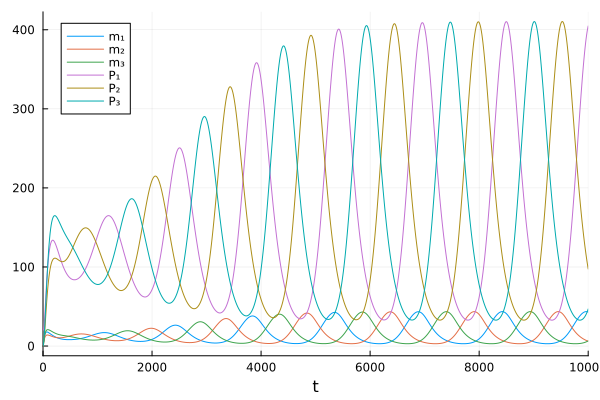

In [32]:
pmap  = (:α => .5, :K => 40, :n => 2, :δ => log(2)/120,
         :γ => 5e-3, :β => log(2)/6, :μ => log(2)/60)
u₀map = [:m₁ => 0., :m₂ => 0., :m₃ => 0., :P₁ => 20., :P₂ => 0., :P₃ => 0.]

# time interval to solve on
tspan = (0., 10000.)

# create the ODEProblem we want to solve
oprob = ODEProblem(rn, u₀map, tspan, pmap)

sol = solve(oprob, Tsit5(), saveat=10.0)
plot(sol)

## Example 4: Finding steady state solutions

In [33]:
Pkg.add("SteadyStateDiffEq")
Pkg.add("HomotopyContinuation")

   Resolving package versions...
  No Changes to `~/Documents/repos/JuliaTutorials/Project.toml`
  No Changes to `~/Documents/repos/JuliaTutorials/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/repos/JuliaTutorials/Project.toml`
  No Changes to `~/Documents/repos/JuliaTutorials/Manifest.toml`


In [34]:
dimer_production = @reaction_network begin
    pₘ, 0 --> mRNA
    pₚ, mRNA --> mRNA + P
    (k₁, k₂), 2P <--> P₂
    d, (mRNA, P, P₂) --> 0
end

Model ##ReactionSystem#314:
Unknowns (3): see unknowns(##ReactionSystem#314)
  mRNA(t)
  P(t)
  P₂(t)
Parameters (5): see parameters(##ReactionSystem#314)
  pₘ
  pₚ
  k₁
  k₂
  ⋮

This numerically solves $\frac{d\mathbf{x}}{dt} = f(\mathbf{x}) = 0$ directly.

In [35]:
p = [:pₘ => 0.5, :pₚ => 2.0, :k₁ => 5.0, :k₂ => 1.0, :d => 1.0]
u0 = [:mRNA => 0.1, :P => 0.0, :P₂ => 0.0]

ssprob = SteadyStateProblem(dimer_production, u0, p)

SteadyStateProblem with uType Vector{Float64}. In-place: true
u0: 3-element Vector{Float64}:
 0.1
 0.0
 0.0

In [36]:
using SteadyStateDiffEq
solve(ssprob, DynamicSS(Rodas5P()))

retcode: Success
u: 3-element Vector{Float64}:
 0.49999999427790315
 0.46332491715580865
 0.26833743088545725

Steady states for "well behaved" ODEs can also be found using *homotopy continuation*.

In [38]:
import HomotopyContinuation

wilhelm_2009_model = @reaction_network begin
    k1, Y --> 2X
    k2, 2X --> X + Y
    k3, X + Y --> Y
    k4, X --> 0
end

Model ##ReactionSystem#326:
Unknowns (2): see unknowns(##ReactionSystem#326)
  Y(t)
  X(t)
Parameters (4): see parameters(##ReactionSystem#326)
  k1
  k2
  k3
  k4

In [39]:
ps = [:k1 => 8.0, :k2 => 2.0, :k3 => 1.0, :k4 => 1.5]

hc_steady_states(wilhelm_2009_model, ps)

3-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [4.500000000000003, 6.000000000000002]
 [0.4999999999999999, 1.9999999999999998]